<a href="https://colab.research.google.com/github/shivangibithel/assignment2/blob/main/FaceRecognition/Face-Recognition-master/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.image import imread
from numpy.linalg import inv
import numpy as np
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/MyDrive/dataset/'
dataset_dir  = os.listdir(dataset_path)

width  = 92
height = 112

Train Images:


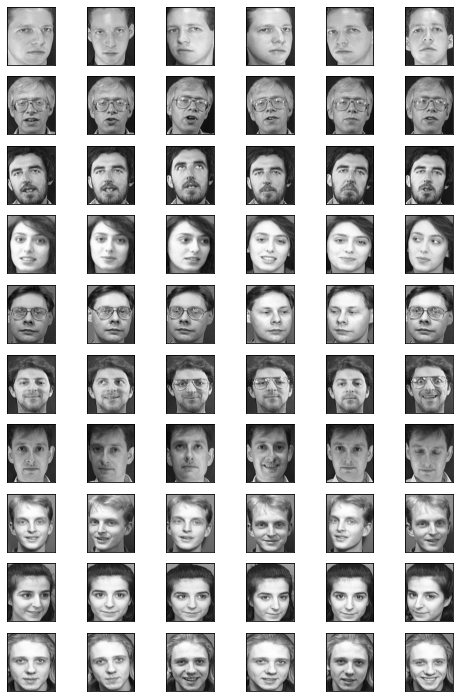

Test Images:


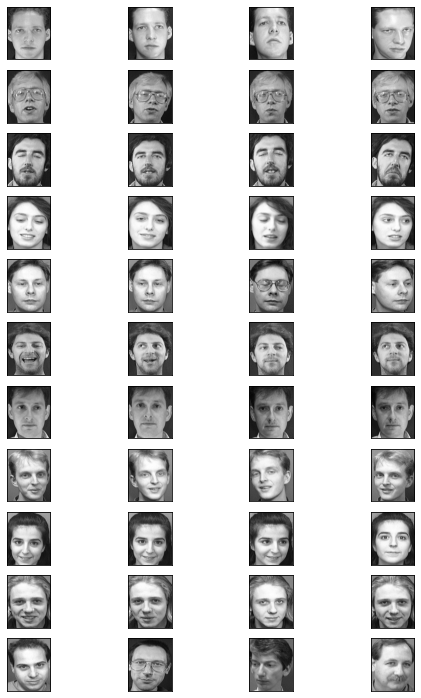

In [4]:
number_of_classes=10
img_in_class=6

print('Train Images:')

# to store all the training images in an array
training_tensor   = np.ndarray(shape=(number_of_classes*img_in_class, height*width), dtype=np.float64)

for i in range(number_of_classes):
    for j in range(img_in_class):
        img = plt.imread(dataset_path + 'training1/s'+str(i+1)+'/'+str(j+1)+'.pgm')
        # copying images to the training array
        training_tensor[img_in_class*i+j,:] = np.array(img, dtype='float64').flatten()
        # plotting the training images
        plt.subplot(number_of_classes,img_in_class,1+img_in_class*i+j)
        plt.imshow(img, cmap='gray')
        plt.subplots_adjust(right=1.2, top=2.5)
        plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
plt.show()

print('Test Images:')
testing_tensor   = np.ndarray(shape=(44, height*width), dtype=np.float64)

for i in range(44):
    img = imread(dataset_path + 'test/'+str(i+1)+'.pgm')
    testing_tensor[i,:] = np.array(img, dtype='float64').flatten()
    plt.subplot(11,4,1+i)
    plt.imshow(img, cmap='gray')
    plt.subplots_adjust(right=1.2, top=2.5)
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
plt.show()

## Apply PCA on the given data and make a database of projected faces

In [5]:
def PCA(training_tensor, number_chosen_components):
    
    mean_face = np.zeros((1,height*width))
    for i in training_tensor:
        mean_face = np.add(mean_face,i)
    mean_face = np.divide(mean_face,float(training_tensor.shape[0])).flatten()
    
#     plt.title('Mean face')
#     plt.imshow(mean_face.reshape(height, width), cmap='gray')
#     plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
#     plt.show()
    
#     print('Normalized faces:')
    normalised_training_tensor = np.ndarray(shape=(training_tensor.shape))
    for i in range(training_tensor.shape[0]):
        normalised_training_tensor[i] = np.subtract(training_tensor[i],mean_face)        
#     for i in range(len(training_tensor)):
#         img = normalised_training_tensor[i].reshape(height,width)
#         plt.subplot(10,6,1+i)
#         plt.imshow(img, cmap='gray')
#         plt.subplots_adjust(right=1.2, top=2.5)
#         plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
#     plt.show()
    cov_matrix = np.cov(normalised_training_tensor)
    cov_matrix = np.divide(cov_matrix,float(training_tensor.shape[0]))
 
    eigenvalues, eigenvectors, = np.linalg.eig(cov_matrix)
    eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

    # Sort the eigen pairs in descending order:
    eig_pairs.sort(reverse=True)
    eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
    eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]
    
    reduced_data = np.array(eigvectors_sort[:number_chosen_components]).transpose()

    proj_data = np.dot(training_tensor.transpose(),reduced_data)
    proj_data = proj_data.transpose()
    
#     print('Projected Data:')
#     for i in range(proj_data.shape[0]):
#         img = proj_data[i].reshape(height,width)
#         plt.subplot(10,10,1+i)
#         plt.imshow(img, cmap='jet')
#         plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
#         plt.subplots_adjust(right=1.2, top=2.5)
#     plt.show()

    wx = np.array([np.dot(proj_data,img) for img in normalised_training_tensor])
    
    return proj_data, wx

In [6]:
# get the projected faces
number_chosen_components = 30
projected_data, projected_sig = PCA(training_tensor, number_chosen_components)
projected_sig.shape

(60, 30)

## Mean of each class and global mean

In [7]:
mew = np.zeros((number_of_classes, number_chosen_components))
M = np.zeros((1,number_chosen_components))

for i in range(number_of_classes):
    xa = projected_sig[img_in_class*i:img_in_class*i+img_in_class,:]
    for j in xa:
        mew[i,:] = np.add(mew[i,:],j)
    mew[i,:] = np.divide(mew[i,:],float(len(xa)))

for i in projected_sig:
    M = np.add(M,i)
M = np.divide(M,float(len(projected_sig)))

M.shape
mew.shape

(10, 30)

## Within class scatter matrix

In [8]:
# normalised within class data
normalised_wc_proj_sig = np.ndarray(shape=(number_of_classes*img_in_class, number_chosen_components), dtype=np.float64)

for i in range(number_of_classes):
    for j in range(img_in_class):
        normalised_wc_proj_sig[i*img_in_class+j,:] = np.subtract(projected_sig[i*img_in_class+j,:],mew[i,:])
normalised_wc_proj_sig.shape

sw = np.zeros((number_chosen_components,number_chosen_components))

for i in range(number_of_classes):
    xa = normalised_wc_proj_sig[img_in_class*i:img_in_class*i+img_in_class,:]
    xa = xa.transpose()
    cov = np.dot(xa,xa.T)
    sw = sw + cov
sw.shape

(30, 30)

## Between class scatter matrix


In [9]:
normalised_proj_sig = np.ndarray(shape=(number_of_classes*img_in_class, number_chosen_components), dtype=np.float64)
for i in range(number_of_classes*img_in_class):
    normalised_proj_sig[i,:] = np.subtract(projected_sig[i,:],M)

sb = np.dot(normalised_proj_sig.T,normalised_proj_sig)
sb = np.multiply(sb,float(img_in_class))
sb.shape

(30, 30)

## Use the criterion function


In [10]:
J = np.dot(inv(sw), sb)
J.shape

(30, 30)

## eigenvalues and eigenvectors

In [11]:
eigenvalues, eigenvectors, = np.linalg.eig(J)
# eigenvectors = abs(eigenvectors)
print('Eigenvectors of Cov(X):')
print(eigenvectors)
# eigenvalues = abs(eigenvalues)
print('Eigenvalues of Cov(X):',eigenvalues)

Eigenvectors of Cov(X):
[[ 1.89401873e-01+0.00000000e+00j  2.15348254e-02+0.00000000e+00j
  -9.67908648e-02+0.00000000e+00j -3.00974657e-02+0.00000000e+00j
  -3.92752842e-02+0.00000000e+00j -4.61945131e-02+0.00000000e+00j
  -4.55540985e-02+0.00000000e+00j -3.84538008e-02+0.00000000e+00j
   2.63646556e-02+0.00000000e+00j  1.75029497e-02-5.23315971e-03j
   1.75029497e-02+5.23315971e-03j  1.14530590e-02+0.00000000e+00j
   3.78547826e-03-1.53739447e-02j  3.78547826e-03+1.53739447e-02j
   1.71735824e-02-4.95436391e-03j  1.71735824e-02+4.95436391e-03j
   1.11423159e-04+3.87703405e-03j  1.11423159e-04-3.87703405e-03j
  -1.30849936e-02+4.00290805e-03j -1.30849936e-02-4.00290805e-03j
   6.46952421e-03+0.00000000e+00j  4.68771107e-03+4.74638339e-03j
   4.68771107e-03-4.74638339e-03j -5.80466395e-03-1.01251686e-03j
  -5.80466395e-03+1.01251686e-03j -8.76067398e-03+0.00000000e+00j
  -4.24350404e-03-3.27438892e-03j -4.24350404e-03+3.27438892e-03j
   9.35391286e-03+0.00000000e+00j  7.94620727e-03+0.

Cumulative proportion of variance explained vector: [0.44995359+0.00000000e+00j 0.63788569+0.00000000e+00j
 0.73555566+0.00000000e+00j 0.82953486+0.00000000e+00j
 0.88630592+0.00000000e+00j 0.93044652+0.00000000e+00j
 0.94880747+0.00000000e+00j 0.96572932+0.00000000e+00j
 0.97583259+0.00000000e+00j 0.97698342+0.00000000e+00j
 0.97813425+5.28617176e-18j 0.97928507+0.00000000e+00j
 0.9804359 +0.00000000e+00j 0.98158673+9.41434069e-18j
 0.98273756+1.28140183e-17j 0.98388839+9.41434069e-18j
 0.98503922+0.00000000e+00j 0.98619005+0.00000000e+00j
 0.98734088+6.12456311e-18j 0.98849171+0.00000000e+00j
 0.98964254+0.00000000e+00j 0.99079337+0.00000000e+00j
 0.9919442 +1.57551393e-18j 0.99309502+0.00000000e+00j
 0.99424585+1.42464841e-18j 0.99539668+0.00000000e+00j
 0.99654751+1.48834603e-17j 0.99769834+0.00000000e+00j
 0.99884917+1.04217468e-17j 1.        +0.00000000e+00j]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


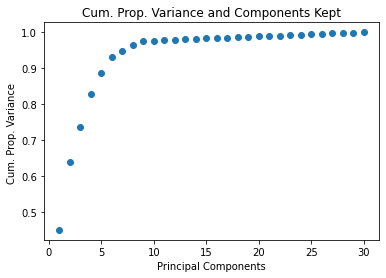

In [12]:
# get corresponding eigenvectors to eigen values
# so as to get the eigenvectors at the same corresponding index to eigen values when sorted
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True)
eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

# Find cumulative variance of each principle component
var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)

# Show cumulative proportion of varaince with respect to components
print("Cumulative proportion of variance explained vector:", var_comp_sum)

# x-axis for number of principal components kept
num_comp = range(1,len(eigvalues_sort)+1)
plt.title('Cum. Prop. Variance and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance ')

plt.scatter(num_comp, var_comp_sum)
plt.show()

In [13]:
print('Number of eigen vectors:',len(eigvalues_sort))

# Choosing the necessary number of principle components
number_chosen_components = 15
print("k:",number_chosen_components)
reduced_data = np.array(eigvectors_sort[:number_chosen_components]).transpose()
reduced_data.shape

Number of eigen vectors: 30
k: 15


(30, 15)

## Fisher faces

In [14]:
projected_sig.shape
FP = np.dot(projected_sig, reduced_data)
FP.shape

(60, 15)

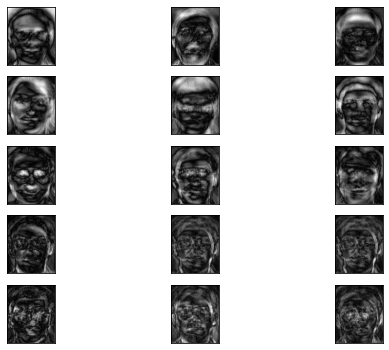

In [15]:
# get projected data ---> eigen space

proj_data1 = np.dot(training_tensor.transpose(),FP)
proj_data1 = proj_data1.transpose()
proj_data1.shape

# plotting of eigen faces --> the information retained after applying lossing transformation
for i in range(proj_data1.shape[0]):
    img = proj_data1[i].reshape(height,width)
    #print(img)
    plt.subplot(10,3,1+i)
    plt.imshow((img.real*img.real + img.imag*img.imag)**0.5, cmap='gray')
    plt.subplots_adjust(right=1.2, top=2.5)
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
plt.show()

## Mean face

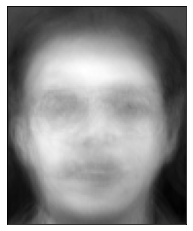

In [16]:
mean_face = np.zeros((1,height*width))

for i in training_tensor:
    mean_face = np.add(mean_face,i)

mean_face = np.divide(mean_face,float(len(training_tensor))).flatten()

plt.imshow(mean_face.reshape(height, width), cmap='gray')
plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
plt.show()

## Testing

6587906.412682065
4537493.3077135505
3808824.521538699
6929115.77344793
3753957.2443638453
4049692.027176282
1817427.566282097
2749296.8989841803
3751655.3089408046
2211899.2405165182
1927541.799048451
4158535.9028022145
1721197.010994663
1356082.1254799177
2628199.676508244
2798468.5847851
3075145.911089634
3353327.013877837
2599482.048002534
3884084.783766356
4077733.6948309457
3780824.7489733174
3007221.723507356
2239989.951997872
1771462.4202939498
2513840.994129096
2787529.169922728
2742056.46485335
3064291.0268250764
3096020.9533322193
4100455.090590454
3631203.575063157
4438846.62775528
3088219.004107329
2546306.5169532774
7697133.049794246
1804521.7620207397
2929661.866200464
2348331.5654977923
4005505.5863260673
6876937.349368572
7417883.4318600735
7895082.155346668
3070181.4614966237


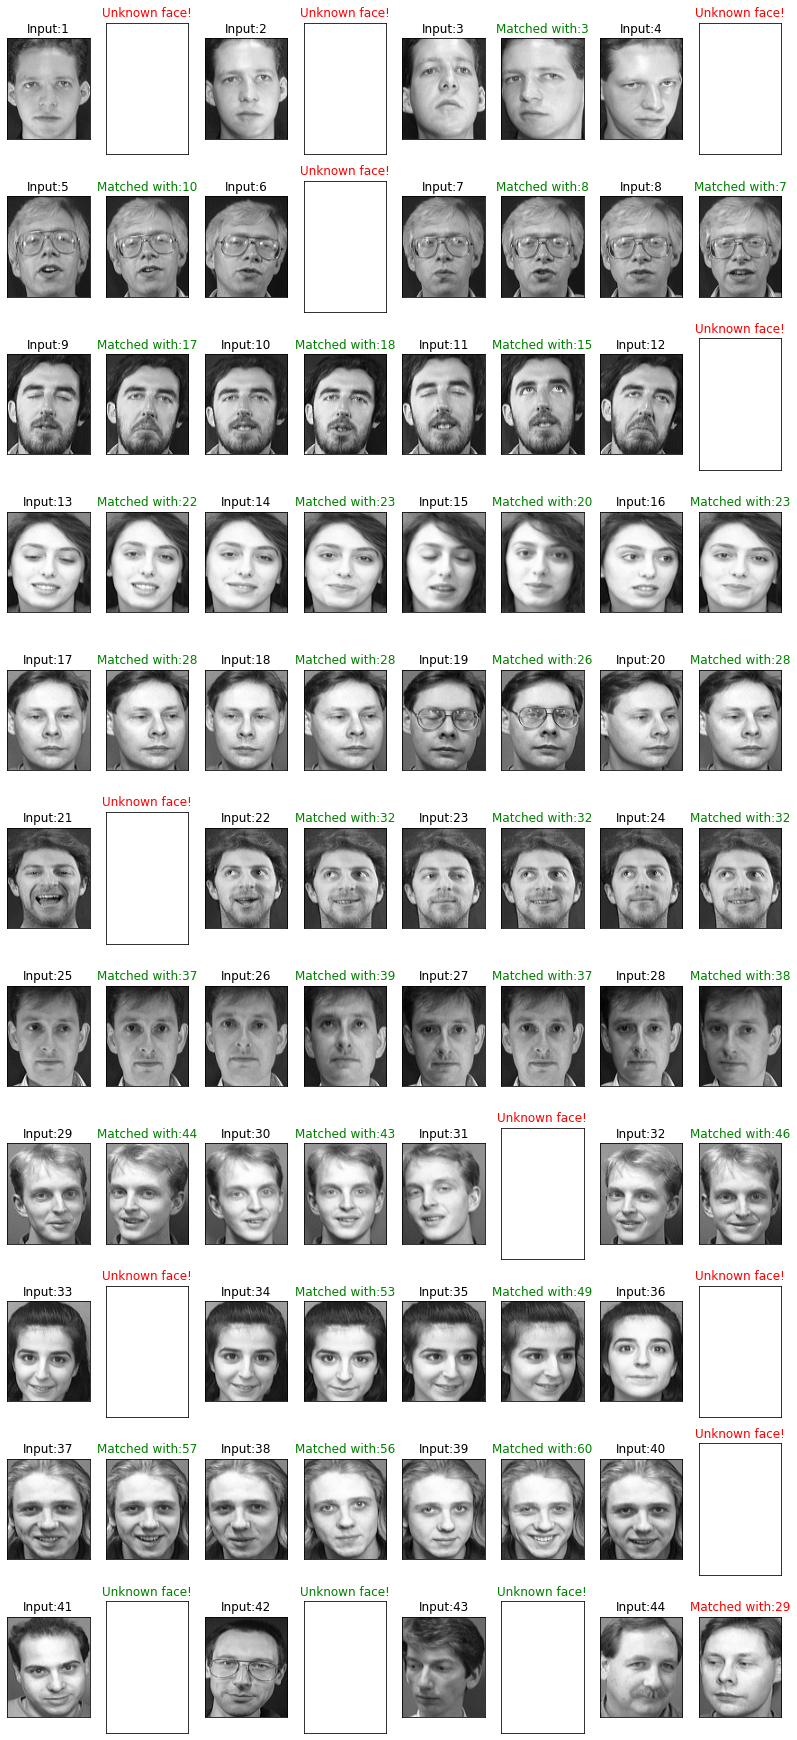

Correct predictions: 33/44 = 75.0%


In [21]:
# Testing all the images

count=0
num_images=0
correct_pred=0
def recogniser(img_number):
    global count,highest_min,num_images,correct_pred
    
    num_images          += 1
    unknown_face_vector = testing_tensor[img_number,:]
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
    plt.subplot(11,8,1+count)
    plt.imshow(unknown_face_vector.reshape(height,width), cmap='gray')
    plt.title('Input:'+str(img_number+1))
    plt.subplots_adjust(right=1.2, top=2.5)
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
    count+=1
    
    PEF = np.dot(projected_data,normalised_uface_vector)
    proj_fisher_test_img = np.dot(reduced_data.T,PEF)
    diff  = FP - proj_fisher_test_img
    norms = np.linalg.norm(diff, axis=1)
    mean_ = np.mean(norms)
    # print(norms)
    # print("mean:",mean_)
    index = np.argmin(norms)

    dist = np.min(norms)
    print(dist)
  


    
    plt.subplot(11,8,1+count)
    
    set_number = int(img_number/4)
#     print(set_number)

    t0 = 4000000
    
#     if(img_number>=40):
#         print(norms[index])
    
    if norms[index] < t0:
      if(index>=(6*set_number) and index<(6*(set_number+1))):
          plt.title('Matched with:'+str(index+1), color='g')
          plt.imshow(training_tensor[index,:].reshape(height,width), cmap='gray')
          correct_pred += 1
      else:
          plt.title('Matched with:'+str(index+1), color='r')
          plt.imshow(training_tensor[index,:].reshape(height,width), cmap='gray')
    else:
        if(img_number>=40):
            plt.title('Unknown face!', color='g')
            correct_pred += 1
        else:
            plt.title('Unknown face!', color='r')
    plt.subplots_adjust(right=1.2, top=2.5)
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
    count+=1
    return dist

fig = plt.figure(figsize=(10, 10))
for i in range(len(testing_tensor)):
    recogniser(i)


plt.show()

print('Correct predictions: {}/{} = {}%'.format(correct_pred, num_images, correct_pred/num_images*100.00))

## Plotting of Accuracy vs m-value for eigenvectors


Total Number of eigenvectors: 30


Text(0.5, 1.0, 'Accuracy vs. k-value')

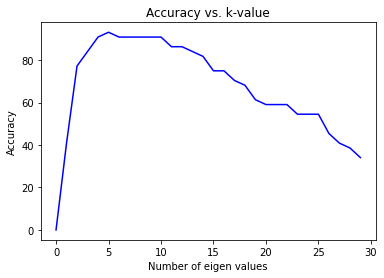

In [22]:
accuracy = np.zeros(len(eigvalues_sort))

def tester(img_number,reduced_data,FP,num_images,correct_pred):
    
    num_images          += 1
    unknown_face_vector = testing_tensor[img_number,:]
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
    PEF = np.dot(projected_data,normalised_uface_vector)
    proj_fisher_test_img = np.dot(reduced_data.T,PEF)
    diff  = FP - proj_fisher_test_img
    norms = np.linalg.norm(diff, axis=1)
    index = np.argmin(norms)
    
    set_number = int(img_number/4)

    t0 = 4000000
    
    if norms[index] < t0:
      if(index>=(6*set_number) and index<(6*(set_number+1))):
          correct_pred += 1
    else:
        if(img_number>=40):
            correct_pred += 1
    
    return num_images,correct_pred

def calculate(k):
    
#     print("k:",k)
    reduced_data = np.array(eigvectors_sort[:k]).transpose()
    
    FP = np.dot(projected_sig, reduced_data)
    
    num_images=0
    correct_pred=0
    
    for i in range(len(testing_tensor)):
        num_images,correct_pred = tester(i,reduced_data,FP,num_images,correct_pred)
#     print(FP.shape)
    accuracy[k] = correct_pred/num_images*100.00
    
print('Total Number of eigenvectors:',len(eigvalues_sort))
for i in range(1,len(eigvalues_sort)):
    calculate(i)
    
fig, axi = plt.subplots()  
axi.plot(np.arange(len(eigvalues_sort)), accuracy, 'b')  
axi.set_xlabel('Number of eigen values')  
axi.set_ylabel('Accuracy')  
axi.set_title('Accuracy vs. k-value') 